# Fit spatiotemporal receptive fields for remapping dataset with pyglmnet

## Imports

In [1]:
import numpy as np
from pyglmnet import GLM
import matplotlib.pyplot as plt
% matplotlib inline
from scipy.io import loadmat, savemat 
import pandas as pd


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Read data file

In [2]:
df = pd.read_csv('probe_m15_d1v3_c21.csv')
df.head()

,probeNum,saccNum,numSaccs,trialNum,rewardedSacc,fixProbe,saccProbe,saccPeakVel,expectedPeakVel,t,...,x_probe,x_curFix,x_oneFixAhead,x_twoFixAhead,y_probe,y_curFix,y_oneFixAhead,y_twoFixAhead,units_1,units_2
0,1,1,3,1,0,1,0,356.574127,368.769958,5110,...,8.791632,-1.660746,-10.204762,-14.338096,15.046200,0.806730,4.722222,-3.077778,231.279940,69.929122
1,2,1,3,1,0,1,0,356.574127,368.769958,5230,...,2.899858,-1.660746,-10.204762,-14.338096,15.046200,0.806730,4.722222,-3.077778,84.576487,0.000000
2,3,1,3,1,0,1,0,356.574127,368.769958,5350,...,8.791632,-1.660746,-10.204762,-14.338096,2.971507,0.806730,4.722222,-3.077778,264.221561,66.565434
3,4,2,3,1,0,1,0,365.157227,346.729919,5470,...,14.683406,-9.732818,-14.338096,-21.104761,-15.140534,4.548117,-3.077778,-3.077778,129.414131,433.025514
4,5,2,3,1,0,0,1,365.157227,346.729919,5590,...,8.791632,-9.732818,-14.338096,-21.104761,2.971507,4.548117,-3.077778,-3.077778,59.805547,73.923103


## define workspace

In [3]:
# define workspace 
N=5 # number of spatial basis functions in each dimension
P=50 # width and height of workspace, in degrees

## Register probe x and y to current and next fixation

In [4]:
df['fix1_x'] = df.x_probe - df.x_oneFixAhead
df['fix1_y'] = df.y_probe - df.y_oneFixAhead

# now make sure that these probes fall within the spatial workspace
df['within_workspace']=(df.fix1_x>-P/2) & (df.fix1_x<P/2) & (df.fix1_y>-P/2) & (df.fix1_y<P/2)

## create some functions

In [5]:
def get_time_bins(df_of_latency, list_of_bins):
    all_time_bins_list = list()
    for i in df_of_latency.index:
        time_bin_list = list()
        for bin_id, bin_edges in enumerate(list_of_bins):
            if df_of_latency.loc[i] >= bin_edges[0] and \
               df_of_latency.loc[i] <= bin_edges[1]: 
                time_bin_list.append(bin_id)
        all_time_bins_list.append(time_bin_list)
    return all_time_bins_list

In [39]:
def design_prior_covariance_for_strf(n_t=8, n_s=25, sigma_t=10., sigma_s=10.):
    """
    Design a prior covariance matrix for STRF estimation
    """
    n_features = n_t * n_s    
    spatialCov = np.zeros([n_features, n_features])
    temporalCov = np.zeros([n_features, n_features])
    PriorCov = np.zeros([n_features, n_features])
    for i in np.arange(0, n_features):
        # Get spatiotemporal indices
        t_i = np.floor(np.float(i) / n_s)
        s_i = i % n_s
        # Convert spatial indices to (x,y) coordinates
        x_i, y_i = s_i % np.sqrt(n_s), np.floor(np.float(s_i) / np.sqrt(n_s))
        
        for j in np.arange(i, n_features):
            # Get spatiotemporal indices
            t_j = np.floor(np.float(j) / n_s)
            s_j = j % n_s
            # Convert spatial indices to (x,y) coordinates
            x_j, y_j = s_j % np.sqrt(n_s), np.floor(np.float(s_i) / np.sqrt(n_s))
        
            
            spatialCov[i, j] = np.exp(-1. / (sigma_s ** 2) * ((x_i - x_j) ** 2 + (y_i - y_j) ** 2))
            spatialCov[j, i] = spatialCov[i, j]
            temporalCov[i, j] = np.exp(-1. / (sigma_t ** 2) * (t_i - t_j) ** 2)
            temporalCov[j, i] = temporalCov[i, j]

            #if i == j:
            #    spatialCov[i, j] += 0.05
            #    temporalCov[i, j] += 0.05

    PriorCov = spatialCov * temporalCov
    PriorCov = 1./ np.max(PriorCov) * PriorCov
    return PriorCov, spatialCov, temporalCov


# USAGE
# C = design_prior_covariance_for_strf(n_t=8, n_s=25, sigma_t=10., sigma_s=10.)
# plt.figure(figsize=(10,10))
# plt.imshow(C, cmap='Greys')
# plt.colorbar()
# plt.show()

In [7]:
def make_gauss2D(shape=(3,3), sigma=0.5, center=(0,0)):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m : m + 1, -n : n + 1]
    y0, x0 = center[1], center[0]
    G = np.exp( -((x - x0) ** 2 + (y - y0) ** 2) / (2. * sigma ** 2) )
    G[G < np.finfo(G.dtype).eps * G.max()] = 0
    return 1. / G.max() * G

In [8]:
def make_spatial_basis(shape=(50,50), sigma=5, n_basis=25):
    """
    Makes a list of Gaussian filters
    
    Parameters
    ----------
    shape: tuple, 
        specifies the image size in pixels
        (should be the same)
    sigma: float,
        specifies the sigma of the Gaussian kernel
    n_basis: int,
        number of basis fuctions
        (has to be a perfect square)
    """
    Basis = list()
    
    n_tiles = np.sqrt(n_basis)
    n_pixels = shape[0]
    centers = np.linspace(start = -n_pixels / 2. + n_pixels / (n_tiles + 1.), 
                          stop = n_pixels / 2. - n_pixels / (n_tiles + 1.),
                          num=n_tiles)
    
    for y in np.arange(n_tiles):
        for x in np.arange(n_tiles):
            G = make_gauss2D(shape=shape, sigma=sigma, center=(centers[x], centers[y]))
            Basis.append(G)
    return Basis


# USAGE
# n_basis = 25
# n_tiles = np.sqrt(n_basis)
# Basis = make_spatial_basis((50,50), sigma=5, n_basis=n_basis)
# plt.figure(figsize=(7,7))
# for i in range(len(Basis)):
#     plt.subplot(np.int(n_tiles), np.int(n_tiles), i+1)
#     plt.imshow(Basis[i], cmap='Greys')
#     plt.axis('off')
# plt.show()

In [9]:
def project_to_basis(I, Basis):
    projection = np.zeros(len(Basis))
    for b in range(len(Basis)):
        projection[b] = np.sum(Basis[b] * I)
    return projection


# USAGE
# I = np.zeros((50,50))
# I[10, 12] = 1.
# vec25 = project_to_basis(I, Basis)
# plt.stem(vec25)
# plt.xlim([-1, 25])
# plt.show()

In [10]:
def make_RF_from_basis(Basis, weights):
    RF = np.zeros(Basis[0].shape)
    for b in range(len(Basis)):
        RF += weights[b] * Basis[b]
    return RF

## Get probes within temporal window(s) of interest

In [11]:
# Define window params
lock_event = 't_sacc_start_lock'
sac_win_earliest = -75
sac_win_latest = 25
sac_win_size = 25
sac_win_inc = 25

# define start and end times for all windows
start_times = range(sac_win_earliest,sac_win_latest,sac_win_inc)
end_times = [x+sac_win_size for x in start_times]
list_of_bins = zip(start_times,end_times)

# now add the time bin variable
df['time_bin']= get_time_bins(df[lock_event], list_of_bins)



In [12]:
df.head()

,probeNum,saccNum,numSaccs,trialNum,rewardedSacc,fixProbe,saccProbe,saccPeakVel,expectedPeakVel,t,...,y_probe,y_curFix,y_oneFixAhead,y_twoFixAhead,units_1,units_2,fix1_x,fix1_y,within_workspace,time_bin
0,1,1,3,1,0,1,0,356.574127,368.769958,5110,...,15.046200,0.806730,4.722222,-3.077778,231.279940,69.929122,18.996394,10.323978,True,[]
1,2,1,3,1,0,1,0,356.574127,368.769958,5230,...,15.046200,0.806730,4.722222,-3.077778,84.576487,0.000000,13.104620,10.323978,True,[]
2,3,1,3,1,0,1,0,356.574127,368.769958,5350,...,2.971507,0.806730,4.722222,-3.077778,264.221561,66.565434,18.996394,-1.750716,True,[1]
3,4,2,3,1,0,1,0,365.157227,346.729919,5470,...,-15.140534,4.548117,-3.077778,-3.077778,129.414131,433.025514,29.021501,-12.062756,False,[]
4,5,2,3,1,0,0,1,365.157227,346.729919,5590,...,2.971507,4.548117,-3.077778,-3.077778,59.805547,73.923103,23.129727,6.049285,True,[3]


Note: Convert units_1 and units_2 to spike counts

## Build design matrix 

### Design spatial basis functions

In [103]:
n_basis = 25
n_shape = 50
Basis = make_spatial_basis(shape=(n_shape,n_shape), sigma=5, n_basis=n_basis)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Compute basis projections by looping through df

In [140]:
from tqdm import tqdm

n_timebins = len(list_of_bins)
X = list()
Y = list()

# Loop through probes
for probe_id in tqdm(df.index):
    
    # Check whether the probe lies within workspace and occured within time window of interest
    if df.loc[probe_id]['within_workspace'] == True &\
       len(df.loc[probe_id]['time_bin']) > 0:
        
        # Initialize features for this probe
        probe_features = np.zeros(n_basis * n_timebins)
        
        # Define an image based on the relative locations
        I = np.zeros(shape=(n_shape, n_shape))
        row = -np.round(df.loc[probe_id]['fix1_y']) + P/2 - 1 
        col = np.round(df.loc[probe_id]['fix1_x']) + P/2 - 1
        I[row, col] = 1
        
        # Compute projection
        basis_projection = project_to_basis(I, Basis)
        
        # Assign to probe features according to which time bins they were assigned
        for bin_ in df.loc[probe_id]['time_bin']:
            cols_of_interest = range(n_basis * bin_, 
                                     n_basis * (bin_ + 1))
            probe_features[cols_of_interest] = basis_projection
        
        X.append(probe_features)
        Y.append(df.loc[probe_id]['units_1'])

X = np.array(X)
Y = np.array(Y)  * 70.0 / 10000.0 #weird normalization

100%|██████████| 33814/33814 [00:36<00:00, 939.27it/s]


In [141]:
print X.shape
print Y.shape

(6252, 100)
(6252,)


## Compute prior covariance matrix

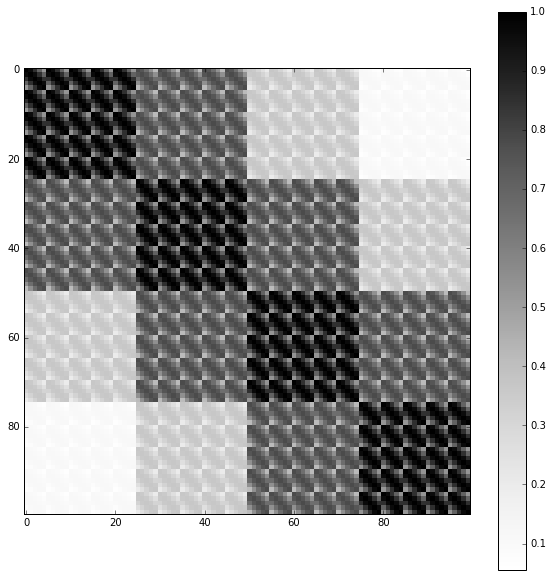

In [142]:
PriorCov, spatialCov, temporalCov = design_prior_covariance_for_strf(n_t=n_timebins, n_s=n_basis, 
                                                                     sigma_t=2., sigma_s=5.)
plt.figure(figsize=(10,10))
plt.imshow(PriorCov, cmap='Greys', interpolation='none')
#plt.imshow(spatialCov[0:25,0:25], cmap='Greys', interpolation='none')
plt.colorbar()
plt.show()

## Fit Tikhonov regularized GLM

In [143]:
from pyglmnet import utils

# Correct non-zero elements
Xdata = X[Y > 0., :]
Ydata = Y[Y > 0.]

n_samples = Xdata.shape[0]
Tau = utils.tikhonov_from_prior(PriorCov, n_samples)


In [144]:
print Xdata.shape
print Ydata.shape

(5987, 100)
(5987,)


In [145]:
glm = GLM(distr='poisson', alpha=0., Tau=Tau, score_metric='pseudo_R2')
glm.fit(Xdata, Ydata)

<
Distribution | poisson
alpha | 0.00
max_iter | 1000.00
lambda: 0.50 to 0.01
>

In [146]:
Ydata_hat = glm[4].predict(Xdata)

In [147]:
print glm.score(Xdata, Ydata_hat)

0.681360018675


In [165]:
weights = glm[1].fit_['beta']

In [166]:
weights.shape

(100, 1)

(-0.5, 49.5, 49.5, -0.5)

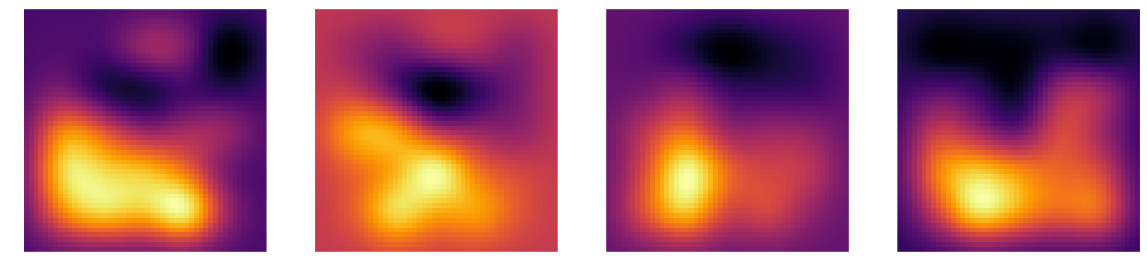

In [167]:
RF0 = make_RF_from_basis(Basis, weights[0:25])
RF1 = make_RF_from_basis(Basis, weights[25:50])
RF2 = make_RF_from_basis(Basis, weights[50:75])
RF3 = make_RF_from_basis(Basis, weights[75:100])
plt.figure(figsize=(20,14))
plt.subplot(1,4,1)
plt.imshow(RF0, cmap='inferno', interpolation='none')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(RF1, cmap='inferno', interpolation='none')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(RF2, cmap='inferno', interpolation='none')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(RF3, cmap='inferno', interpolation='none')
plt.axis('off')

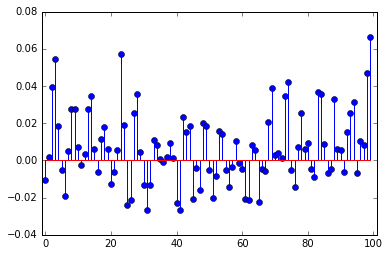

In [128]:
plt.stem(weights)
plt.xlim([-1, 101])
plt.show()


In [134]:
list_of_bins

[(-75, -50), (-50, -25), (-25, 0), (0, 25)]